## ETF 탐험대: 잠재력 있는 ETF를 찾아서!

NH투자증권에서 제공한 MTS 컨텐츠 데이터와 미국 주식/ETF 시세 정보를 활용해 성장 잠재력이 높은 ETF를 발굴하고 추천하는 것을 목표로 진행하였습니다. 이를 통해 투자자들이 높은 수익을 기대하면서도 리스크를 잘 관리할 수 있는 ETF를 선택할 수 있도록 돕고자 했습니다. 핵심 목표는 투자자에게 최적의 투자 전략을 제안할 수 있는 맞춤형 ETF 큐레이션 서비스를 기획하는 것입니다.

1. **데이터 수집 및 전처리**: 이번 분석에서는 NH투자증권이 제공한 ETF 데이터와 yfinance 라이브러리를 통해 수집한 S&P 500 지수 데이터를 활용했습니다. 결측치는 중앙값으로 보정했고, 분석에 꼭 필요한 변수들만 골라 사용했습니다.
2. **특성 엔지니어링**: ETF의 변동성, 수익률, 그리고 S&P 500 지수와의 비교를 통해 ETF의 주요 특성을 파악했습니다. 이동 표준편차로 변동성을 계산했고, S&P 500 지수와의 성과 비교를 통해 ETF의 상대적 효율성을 평가했습니다. 또한, 리스크 조정 수익률도 계산해 ETF의 안정성과 수익성을 함께 살펴보았습니다.
3. **모델 구축 및 평가**: 랜덤 포레스트 회귀 모델을 사용해 ETF의 다음 기간 수익률을 예측했습니다. 데이터를 훈련 세트와 테스트 세트로 나눠 모델을 학습시켰고, 교차 검증을 통해 성능을 평가했습니다. 모델의 설명력은 다소 낮았지만, 개선의 여지가 있는 방향성을 확인할 수 있었습니다.
4. **외부 정보 통합 및 생성형 AI 적용**: 외부 금융 뉴스 데이터를 활용해 ETF의 최신 정보를 수집했습니다. 생성형 AI를 사용해 ETF에 대한 요약 설명을 생성하여 투자자들이 이해하기 쉽게 제공했습니다. 이를 통해 투자자들이 보다 현명한 매수/매도 결정을 내릴 수 있도록 했습니다.

In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
import datetime as dt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error
from sklearn.model_selection import train_test_split, cross_val_score
import matplotlib.pyplot as plt
import seaborn as sns
import os
di = 'NH_data/'
os.listdir(di)

['NH_CONTEST_NHDATA_IFW_OFW_IFO.csv',
 '(╞└└╠╕з)_║╨╝о║╕░э╝н.docx',
 'NH_CONTEST_ETF_SOR_IFO.csv',
 'NH_CONTEST_NW_FC_STK_IEM_IFO.csv',
 '.ipynb_checkpoints',
 'NH_CONTEST_NHDATA_STK_DD_IFO.csv',
 'NH_data.zip',
 '2024NH┼ї└┌┴ї▒╟║Є╡е└╠┼═░ц┴°┤ы╚╕_╡е└╠┼═_╜║┼░╕╢.xlsx',
 'NH_CONTEST_STK_DT_QUT.csv',
 'NH_CONTEST_DATA_HISTORICAL_DIVIDEND.csv',
 'NH_CONTEST_DATA_ETF_HOLDINGS.csv',
 'NH_CONTEST_NHDATA_CUS_TP_IFO.csv']

In [15]:
import pandas as pd
import yfinance as yf
from datetime import datetime

# 데이터 불러오기
price_data = pd.read_csv('NH_data/NH_CONTEST_ETF_SOR_IFO.csv')  # ETF 가격 데이터
dividend_data = pd.read_csv('NH_data/NH_CONTEST_DATA_HISTORICAL_DIVIDEND.csv')  # 배당 데이터


price_data['etf_iem_cd'] = price_data['etf_iem_cd'].str.rstrip()
price_data.sort_values(by=['etf_iem_cd', 'bse_dt'], ascending=True, inplace=True)
price_data['etf_tck_cd'] = price_data['etf_iem_cd']

# ETF 가격 데이터와 배당 데이터 병합
merged_data = pd.merge(price_data, dividend_data, how='left', on='etf_tck_cd')

# 배당 주기를 고려한 연간 배당금 계산
def annualize_dividend(row):
    frequency = row['ddn_pym_fcy_cd']
    dividend = row['ddn_amt']
    
    if frequency == 'Monthly':
        return dividend * 12
    elif frequency == 'Quarterly':
        return dividend * 4
    elif frequency == 'Weekly':
        return dividend * 52
    elif frequency == 'SemiAnnual':
        return dividend * 2
    elif frequency == 'Annual':
        return dividend
    else:
        return 0

merged_data['annualized_dividend'] = merged_data.apply(annualize_dividend, axis=1)

# 5. 배당 수익률 계산
merged_data['dividend_yield'] = merged_data['annualized_dividend'] / merged_data['mm3_tot_pft_rt']

# 6. S&P 500, 금리, 인플레이션 데이터 추가
# S&P 500 데이터 다운로드
sp500 = yf.download('^GSPC', start='2023-01-01', end='2024-08-27')['Adj Close'].reset_index()
sp500.columns = ['date', 'sp500']

# 금리 데이터 다운로드 (미국 10년물 국채 금리)
treasury_yield = yf.download('^TNX', start='2023-01-01', end='2024-08-27')['Adj Close'].reset_index()
treasury_yield.columns = ['date', 'treasury_yield']

# 7. 날짜 기준으로 ETF 데이터와 외부 데이터 병합
# 날짜 형식을 통일
# merged_data['bse_dt'] = pd.to_datetime(merged_data['bse_dt'], format='%Y-%m-%d')
merged_data['bse_dt'] = merged_data['bse_dt'].apply(lambda x: pd.to_datetime(str(x), format='%Y%m%d'))


# 외부 데이터들도 날짜 형식 변환
sp500['date'] = pd.to_datetime(sp500['date'])
treasury_yield['date'] = pd.to_datetime(treasury_yield['date'])

# 병합 (ETF 데이터와 S&P500, 금리, 인플레이션 데이터)
merged_data = pd.merge(merged_data, sp500, how='left', left_on='bse_dt', right_on='date')
merged_data = pd.merge(merged_data, treasury_yield, how='left', left_on='bse_dt', right_on='date')

# 필요 없는 date 컬럼 삭제
# merged_data.drop(columns=['date'], inplace=True)

# 8. 티커 중복 처리: 티커별로 평균 수익률 계산
# groupby를 사용하여 티커별 평균 수익률 계산
average_data = merged_data.groupby('etf_tck_cd').agg({
    'mm3_tot_pft_rt': 'mean',  # 3개월 총수익률 평균
    'dividend_yield': 'mean',  # 배당 수익률 평균
    'sp500': 'mean',           # S&P500 평균
    'treasury_yield': 'mean',  # 금리 평균
    'annualized_dividend': 'mean'  # 연간 배당금 평균
}).reset_index()

# 9. 총 예측 수익률 계산 (기존 수익률 + 배당 수익률)
average_data['total_expected_return'] = average_data['mm3_tot_pft_rt'] + average_data['dividend_yield']

# 10. 상위 10개의 성장 잠재력 높은 ETF 선택
top_10_etf = average_data.nlargest(10, 'total_expected_return')

# 11. 결과 출력
print(top_10_etf[['etf_tck_cd', 'total_expected_return']])


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


   etf_tck_cd  total_expected_return
28       NVDY              26.710414
44       TSLY              15.015520
35        SMH              14.330510
7         DIA              13.931688
2        APLY              12.938887
37       SOXX              11.174423
36       SOXQ              10.684057
42       SPYG               9.525338
24        MGK               9.368537
31       QQQM               9.280846


In [37]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error

# 1. 데이터 로드 (NH_CONTEST 및 외부 데이터)
etf_data = pd.read_csv(di +'NH_CONTEST_ETF_SOR_IFO.csv')
stock_data = pd.read_csv(di +'NH_CONTEST_STK_DT_QUT.csv')
etf_data['bse_dt'] = pd.to_datetime(etf_data['bse_dt'], format='%Y%m%d')
stock_data['bse_dt'] = pd.to_datetime(stock_data['bse_dt'], format='%Y%m%d')
etf_data['etf_iem_cd'] = etf_data['etf_iem_cd'].str.rstrip()

# 외부 데이터를 yfinance에서 가져오기 (예: S&P 500 지수)
sp500 = yf.download('^GSPC', start='2020-01-01', end='2024-08-27')

# 2. 데이터 전처리 (결측치 처리, 불필요한 칼럼 제거 등)
etf_data.fillna(0) 
etf_data = etf_data[['bse_dt', 'etf_iem_cd', 'mm3_tot_pft_rt', 'etf_sor', 'vty_z_sor']]  # 필요한 컬럼만 선택

# 3. 특성 엔지니어링
# ETF의 과거 수익률, 변동성 등을 계산
etf_data['ETF_Volatility'] = etf_data['vty_z_sor'].rolling(window=5).std()  # 변동성 계산

# S&P 500과 ETF 성과 비교
etf_data = etf_data.merge(sp500[['Close']], left_on='bse_dt', right_index=True, how='left')
etf_data['SP500_Return'] = sp500['Close'].pct_change()  # S&P500 수익률
etf_data['Risk_Adjusted_Return'] = etf_data['mm3_tot_pft_rt'] / etf_data['ETF_Volatility'] 
# 4. 모델 학습 준비
X = etf_data[['mm3_tot_pft_rt', 'etf_sor', 'ETF_Volatility', 'SP500_Return', 'Risk_Adjusted_Return']].fillna(0)
y = etf_data['mm3_tot_pft_rt'].shift(-1).fillna(0)  

# 훈련/테스트 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 5. 모델 구축 및 학습
model = RandomForestRegressor(n_estimators=100, random_state=42)
cross_val_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
model.fit(X_train, y_train)

# 6. 모델 평가
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")
print(f"R2 Score: {r2}")
print(f"Mean Absolute Percentage Error: {mape}")


# 7. 예측 및 성장 잠재력 높은 ETF 발굴
etf_data['Predicted_Return'] = model.predict(X)
top_etfs = etf_data.groupby('etf_iem_cd', as_index=False)['Predicted_Return'].mean()
top_etfs = top_etfs.sort_values(by='Predicted_Return', ascending=False).head(10)
print("Top 10 성장 잠재력 높은 ETF:")
print(top_etfs[['etf_iem_cd', 'Predicted_Return']])

[*********************100%***********************]  1 of 1 completed


Mean Squared Error: 46.382628620120684
R2 Score: 0.2494687669620217
Mean Absolute Percentage Error: 7.534429235008925
Top 10 성장 잠재력 높은 ETF:
   etf_iem_cd  Predicted_Return
28       NVDY         25.206193
35        SMH         13.584800
2        APLY         12.534896
44       TSLY         11.378596
37       SOXX          9.988208
42       SPYG          9.319709
53        XLU          8.745125
36       SOXQ          8.730954
24        MGK          8.582189
12       GOOY          8.108564


In [41]:
top_etfs

,etf_iem_cd,Predicted_Return
28,NVDY,25.206193
35,SMH,13.584800
2,APLY,12.534896
44,TSLY,11.378596
37,SOXX,9.988208
42,SPYG,9.319709
53,XLU,8.745125
36,SOXQ,8.730954
24,MGK,8.582189
12,GOOY,8.108564


In [47]:
top_etfs = top_etfs.rename(columns = {'etf_iem_cd': 'etf_tck_cd'})
final_merge = pd.merge(top_etfs, average_data[['etf_tck_cd', 'total_expected_return']], on='etf_tck_cd', how='outer').dropna()
final_merge

,etf_tck_cd,Predicted_Return,total_expected_return
0,NVDY,25.206193,26.710414
1,SMH,13.584800,14.330510
2,APLY,12.534896,12.938887
3,TSLY,11.378596,15.015520
4,SOXX,9.988208,11.174423
5,SPYG,9.319709,9.525338
6,XLU,8.745125,9.259289
7,SOXQ,8.730954,10.684057
8,MGK,8.582189,9.368537
9,GOOY,8.108564,8.482259


In [50]:
import openai
import requests
from sklearn.ensemble import RandomForestRegressor
import pandas as pd

# OpenAI API 설정
openai.api_key = 'openai.api_key 입력'
newsorg_api_key = 'newsorg_api_key 입력'
fred_api_key = 'fred_api_key 입력'

# 외부 데이터 검색 (예: 금융 뉴스 API 사용)
def search_etf_news(etf_code):
    # 금융 뉴스 검색 API 호출 (예시 API: 뉴스 또는 금융 데이터 제공 플랫폼 사용)
    url = "https://newsapi.org/v2/everything?q={}&apiKey={}" .format(etf_code, newsorg_api_key)
    response = requests.get(url)
    news_data = response.json()
    
    # 뉴스 제목과 내용 요약 추출
    articles = news_data['articles'][:3]  # 상위 3개의 기사만 추출
    summaries = []
    
    for article in articles:
        title = article['title']
        description = article['description']
        summaries.append(f"Title: {title}\nDescription: {description}")
    
    return "\n\n".join(summaries)

# 생성형 AI로 ETF 설명 생성 (RAG 방식 적용)
def generate_etf_summary(etf_code, predicted_return, retrieved_info):
    prompt = f"ETF {etf_code}의 예측 수익률은 {predicted_return:.2f}%입니다. 아래 제공된 최신 정보와 함께 이 ETF에 대해 \"한국어\"로, 한 문단 정도의 요약으로 설명해 주세요. 예측 수익률과 최신 정보를 바탕으로 \'매수\' 혹은 \'매도\' 중 판단해주세요. \n\n{retrieved_info}\n\n"
    messages = [
        {
            "role": "system",
            "content": [
                {"type": "text", "text": prompt}
            ] }
    ]
    
    
    response = openai.chat.completions.create(
        model="gpt-4o-mini",
        messages=messages,
        max_tokens=200
    )
    
    
    return response.choices[0].message.content


# RAG를 통한 성장 잠재력 높은 ETF 추천
def recommend_etfs(data):
    # 예측된 상위 ETF 추출
    top_etfs = data.sort_values(by='Predicted_Return', ascending=False).head(5)
    
    for idx, row in top_etfs.iterrows():
        etf_code = row['etf_tck_cd']
        predicted_return = row['Predicted_Return']
        
        # 1) 외부에서 관련 정보를 검색 (Retrieval)
        retrieved_info = search_etf_news(etf_code)
        
        # 2) 검색된 정보와 예측 데이터를 기반으로 설명 생성 (Augmented Generation)
        summary = generate_etf_summary(etf_code, predicted_return, retrieved_info)
        
        # 결과 출력
        print(f"ETF: {etf_code}, 예상 수익률: {predicted_return:.2f}%")
        print(f"설명: {summary}\n")
        print("=============================================")
        

# 5. 전체 파이프라인 실행
if __name__ == "__main__":
    recommend_etfs(final_merge)


ETF: NVDY, 예상 수익률: 25.21%
설명: YieldMax NVDA Option Income Strategy ETF (NVDY)는 최근 투자자들 사이에서 많은 주목을 받고 있는 ETF로, Nvidia 주식에 대한 투자 노출을 제공합니다. 이 ETF는 놀라운 25.21%의 예측 수익률과 함께, 77%의 배당 수익률을 자랑합니다. 포트폴리오의 큰 비중인 Nvidia는 시장에서 가장 인기 있는 주식 중 하나로, 기술주에 대한 기대감이 커지고 있습니다. 이러한 정보들을 종합적으로 고려할 때, NVDY는 높은 수익률과 배당금을 통해 매력적인 투자 기회를 제공하므로 '매수'를 권장합니다.

ETF: SMH, 예상 수익률: 13.58%
설명: ETF SMH는 반도체 기업에 투자하는 상장지수펀드(ETF)로, 최근 예측 수익률이 13.58%로 나타났습니다. 이 ETF는 반도체 산업의 지속적인 성장세와 기술 발전에 힘입어 긍정적인 투자 성과를 기대할 수 있습니다. 제공된 최신 정보는 연예인이나 스포츠 관련 내용으로 ETF와 직접적인 연결 고리는 크지 않지만, 산업 전반의 흐름과 사회적 이슈에 대한 반응은 시장에 간접적인 영향을 줄 수 있습니다. 예측 수익률이 높기 때문에, 현재의 경제적 환경과 반도체 산업의 전망을 고려할 때 SMH를 '매수'하는 것이 바람직할 것으로 판단됩니다.

ETF: APLY, 예상 수익률: 12.53%
설명: ETF APLY의 예측 수익률은 12.53%로, 이는 상대적으로 높은 수익을 기대할 수 있는 투자처로 평가됩니다. 최근 YieldMax™ ETFs의 배당금 지급 일정 변경과 Purpose Investments Inc.의 배당 발표 등 긍정적인 소식이 전해지고 있습니다. 이러한 배경을 고려할 때, APLY는 매수할 만한 가치가 있는 ETF로 판단됩니다. 따라서, 현재 시점에서 APLY를 매수하는 것이 바람직할 것입니다.

ETF: TSLY, 예상 수익률: 11.38%
설명: YieldMax TSLA Option Income Strategy

## 추가 분석.

In [2]:
columns = {
    'tck_iem_cd': '티커종목코드',
    'fc_sec_krl_nm': '외화증권한글명',
    'fc_sec_eng_nm': '외화증권영문명',
    'stk_etf_dit_cd': '주식/ETF구분코드',
    'ltg_tot_stk_qty': '상장주식총수량',
    'fc_mkt_dit_cd': '외화시장구분코드',
    'co_adr': '회사주소',
    'web_adr': '웹주소',
    'btp_cfc_nm': '업종분류명',
    'ceo_nm': 'CEO명',
    'eng_utk_otl_cts': '영문사업개요내용',
    'ser_cfc_nm': '섹터분류명',
    'ids_nm': '산업명',
    'mkt_pr_tot_amt': '시가총액',
    'bse_dt': '거래일자',
    'iem_ong_pr': '종목시가',
    'iem_hi_pr': '종목고가',
    'iem_low_pr': '종목저가',
    'iem_end_pr': '종목종가',
    'bf_dd_cmp_ind_pr': '전일대비증감가격',
    'bf_dd_cmp_ind_rt': '전일대비증감율',
    'acl_trd_qty': '누적거래수량',
    'trd_cst': '거래대금',
    'sll_cns_sum_qty': '매도체결합계수량',
    'byn_cns_sum_qty': '매수체결합계수량',
    'sby_bse_xcg_rt': '환율',
    'tot_hld_act_cnt': '총보유계좌수',
    'tot_hld_qty': '총보유수량',
    'tco_avg_hld_qty': '당사평균보유수량',
    'tco_avg_hld_wht_rt': '당사평균보유비중비율',
    'tco_avg_eal_pls': '당사평균평가손익',
    'tco_avg_phs_uit_pr': '당사평균매입단가',
    'tco_avg_pft_rt': '당사평균수익율',
    'tco_avg_hld_te_dd_cnt': '당사평균보유기간일수',
    'dist_hnk_pct10_nmv': '분포상위10퍼센트수치',
    'dist_hnk_pct30_nmv': '분포상위30퍼센트수치',
    'dist_hnk_pct50_nmv': '분포상위50퍼센트수치',
    'dist_hnk_pct70_nmv': '분포상위70퍼센트수치',
    'dist_hnk_pct90_nmv': '분포상위90퍼센트수치',
    'bse_end_pr': '기준종가',
    'lss_ivo_rt': '손실투자자비율',
    'pft_ivo_rt': '수익투자자비율',
    'ifw_act_cnt': '신규매수계좌수',
    'ofw_act_cnt': '전량매도계좌수',
    'vw_tgt_cnt': '종목조회건수',
    'rgs_tgt_cnt': '관심종목등록건수',
    'ifw_ofw_dit_cd': '유입/유출구분코드',
    'ifw_ofw_tck_cd': '유입/유출티커코드',
    'ifw_ofw_amt_wht_rt': '유입/유출금액비중',
    'ifw_ofw_rnk': '유입/유출랭크',
    'cus_cgr_llf_cd': '고객구성대분류코드',
    'cus_cgr_mlf_cd': '고객구성중분류코드',
    'cus_cgr_act_cnt_rt': '고객구성계좌수비율',
    'cus_cgr_ivs_rt': '고객구성투자비율',
    'etf_tck_cd': '대상 ETF 티커',
    'mkt_vlu': '보유 종목의 가치 (USD)',
    'stk_qty': '보유 종목의 주수 (주)',
    'wht_pct': '보유 종목의 비중 (%)',
    'sec_tp': '보유 종목의 타입',
    'ediv_dt': '배당락일',
    'ddn_amt': '배당금',
    'aed_stkp_ddn_amt': '수정 배당금',
    'ddn_bse_dt': '배당 기준일',
    'ddn_pym_dt': '지급일',
    'pba_dt': '공시일',
    'ddn_pym_fcy_cd': '배당 주기',
    'mm1_tot_pft_rt': '1개월총수익율',
    'mm3_tot_pft_rt': '3개월총수익율',
    'yr1_tot_pft_rt': '1년총수익율',
    'etf_sor': 'ETF점수',
    'etf_z_sor': 'ETFZ점수',
    'z_sor_rnk': 'Z점수순위',
    'acl_pft_rt_z_sor': '누적수익율Z점수',
    'ifo_rt_z_sor': '정보비율Z점수',
    'shpr_z_sor': '샤프지수Z점수',
    'crr_z_sor': '상관관계Z점수',
    'trk_err_z_sor': '트래킹에러Z점수',
    'mxdd_z_sor': '최대낙폭Z점수',
    'vty_z_sor': '변동성Z점수'
}

In [3]:
df_custm = pd.read_csv(di+'NH_CONTEST_NHDATA_CUS_TP_IFO.csv')
df_tkinfo = pd.read_csv(di + 'NH_CONTEST_NHDATA_STK_DD_IFO.csv')
df_tkinfo['tck_iem_cd'] = df_tkinfo['tck_iem_cd'].str.rstrip()
df_custm['tck_iem_cd'] = df_custm['tck_iem_cd'].str.rstrip()

df_tkinfo

,bse_dt,tck_iem_cd,tot_hld_act_cnt,tot_hld_qty,tco_avg_hld_qty,tco_avg_hld_wht_rt,tco_avg_eal_pls,tco_avg_phs_uit_pr,tco_avg_pft_rt,tco_avg_hld_te_dd_cnt,...,dist_hnk_pct50_nmv,dist_hnk_pct70_nmv,dist_hnk_pct90_nmv,bse_end_pr,lss_ivo_rt,pft_ivo_rt,ifw_act_cnt,ofw_act_cnt,vw_tgt_cnt,rgs_tgt_cnt
0,20240730,AAL,2705,313122,115.76,14.86,-491381.62,20809.67,-22.75,1.0,...,20812.000,23336.400,25598.071,14414.531,0.9811,0.0189,5,4,655,6
1,20240711,AAL,2717,304962,112.24,14.38,-389528.74,20895.44,-18.34,1.0,...,20853.000,23338.000,25598.533,15449.399,0.9382,0.0611,5,11,1353,12
2,20240710,AAL,2721,303099,111.39,14.53,-421285.00,20907.40,-19.93,1.0,...,20873.000,23336.400,25598.533,15189.803,0.9662,0.0338,6,12,619,14
3,20240610,AAL,2761,277875,100.64,14.72,-377206.65,21030.96,-19.25,3.0,...,20978.000,23349.318,25608.000,15719.313,0.9377,0.0623,27,6,406,0
4,20240529,AAL,2615,227029,86.82,15.32,-182141.06,21412.94,-10.30,1.0,...,21418.000,23506.000,25680.509,18271.678,0.8172,0.1816,6,21,2100,15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81633,20240613,ZS,176,2123,12.06,5.53,63116.45,264799.14,2.05,1.0,...,262808.000,296430.333,350410.333,260169.974,0.5455,0.4545,19,1,185,8
81634,20240823,ZS,168,1926,11.46,5.82,66275.68,266174.23,2.24,1.0,...,269766.889,294261.000,350410.333,264214.302,0.5714,0.4286,0,2,53,0
81635,20240805,ZS,174,1985,11.41,5.28,-302673.13,266417.38,-10.23,3.0,...,269822.250,292272.500,350410.333,232717.056,0.7701,0.2299,1,6,108,1
81636,20240712,ZS,186,2101,11.30,5.64,147470.45,266621.34,5.07,1.0,...,269822.250,292031.000,350052.250,270389.192,0.4946,0.5054,0,4,156,8


In [4]:
df_custm.rename(columns=columns, inplace=True)
df_tkinfo.rename(columns=columns, inplace=True)

df_custm['고객구성중분류코드'] = df_custm['고객구성중분류코드'].replace({
    11: '투자고수',
    12: '일반투자자',
    21: '~29',
    22: '30~39',
    23: '40~49',
    24: '50~59',
    25: '60~',
    31: '~3천만원',
    32: '3천만원~1억원미만',
    33: '1억원이상~10억원미만',
    34: '10억원~'
})
df_custm

,거래일자,티커종목코드,고객구성대분류코드,고객구성중분류코드,고객구성계좌수비율,고객구성투자비율
0,20240826,AAL,2,30~39,37.2608,37.5675
1,20240826,AAL,2,60~,4.8405,11.8565
2,20240826,AAL,2,~29,21.4259,11.5923
3,20240826,AAL,2,40~49,23.9400,21.7531
4,20240816,AAL,2,~29,21.4740,11.7051
...,...,...,...,...,...,...
1194995,20240612,ZS,2,50~59,25.3165,23.7650
1194996,20240529,ZS,3,~3천만원,36.8421,11.7457
1194997,20240819,ZS,2,~29,14.7059,7.2295
1194998,20240819,ZS,2,40~49,28.8235,25.3286


In [5]:
df_tkinfo.head()

,거래일자,티커종목코드,총보유계좌수,총보유수량,당사평균보유수량,당사평균보유비중비율,당사평균평가손익,당사평균매입단가,당사평균수익율,당사평균보유기간일수,...,분포상위50퍼센트수치,분포상위70퍼센트수치,분포상위90퍼센트수치,기준종가,손실투자자비율,수익투자자비율,신규매수계좌수,전량매도계좌수,종목조회건수,관심종목등록건수
0,20240730,AAL,2705,313122,115.76,14.86,-491381.62,20809.67,-22.75,1.0,...,20812.0,23336.400,25598.071,14414.531,0.9811,0.0189,5,4,655,6
1,20240711,AAL,2717,304962,112.24,14.38,-389528.74,20895.44,-18.34,1.0,...,20853.0,23338.000,25598.533,15449.399,0.9382,0.0611,5,11,1353,12
2,20240710,AAL,2721,303099,111.39,14.53,-421285.00,20907.40,-19.93,1.0,...,20873.0,23336.400,25598.533,15189.803,0.9662,0.0338,6,12,619,14
3,20240610,AAL,2761,277875,100.64,14.72,-377206.65,21030.96,-19.25,3.0,...,20978.0,23349.318,25608.000,15719.313,0.9377,0.0623,27,6,406,0
4,20240529,AAL,2615,227029,86.82,15.32,-182141.06,21412.94,-10.30,1.0,...,21418.0,23506.000,25680.509,18271.678,0.8172,0.1816,6,21,2100,15


In [6]:
for i in range(1, 4):
    display(df_custm[(df_custm['고객구성대분류코드'] == i) & (df_custm['거래일자'] == 20240826) &  (df_custm['티커종목코드'] == 'AAL')][['고객구성중분류코드', '고객구성계좌수비율', '고객구성투자비율']])
    display(df_custm[(df_custm['고객구성대분류코드'] == i) & (df_custm['거래일자'] == 20240826) &  (df_custm['티커종목코드'] == 'AAL')][['고객구성중분류코드', '고객구성계좌수비율', '고객구성투자비율']].sum())    

,고객구성중분류코드,고객구성계좌수비율,고객구성투자비율
549,투자고수,1.5385,1.6763
636,일반투자자,98.4615,98.3237


고객구성중분류코드    투자고수일반투자자
고객구성계좌수비율        100.0
고객구성투자비율         100.0
dtype: object

,고객구성중분류코드,고객구성계좌수비율,고객구성투자비율
0,30~39,37.2608,37.5675
1,60~,4.8405,11.8565
2,~29,21.4259,11.5923
3,40~49,23.9400,21.7531
66,50~59,12.5328,17.2306


고객구성중분류코드    30~3960~~2940~4950~59
고객구성계좌수비율                    100.0
고객구성투자비율                     100.0
dtype: object

,고객구성중분류코드,고객구성계좌수비율,고객구성투자비율
110,3천만원~1억원미만,19.3996,29.6157
112,1억원이상~10억원미만,8.5178,34.8403
114,~3천만원,71.7073,26.6342
116,10억원~,0.3377,8.9096


고객구성중분류코드    3천만원~1억원미만1억원이상~10억원미만~3천만원10억원~
고객구성계좌수비율                             99.9624
고객구성투자비율                              99.9998
dtype: object

In [7]:
df_custm[(df_custm['고객구성대분류코드'] == 1) & (df_custm['거래일자'] == 20240826) &  (df_custm['티커종목코드'] == 'AAL')][['고객구성중분류코드', '고객구성계좌수비율', '고객구성투자비율']]


,고객구성중분류코드,고객구성계좌수비율,고객구성투자비율
549,투자고수,1.5385,1.6763
636,일반투자자,98.4615,98.3237


In [8]:
df_tkinfo.columns

Index(['거래일자', '티커종목코드', '총보유계좌수', '총보유수량', '당사평균보유수량', '당사평균보유비중비율',
       '당사평균평가손익', '당사평균매입단가', '당사평균수익율', '당사평균보유기간일수', '분포상위10퍼센트수치',
       '분포상위30퍼센트수치', '분포상위50퍼센트수치', '분포상위70퍼센트수치', '분포상위90퍼센트수치', '기준종가',
       '손실투자자비율', '수익투자자비율', '신규매수계좌수', '전량매도계좌수', '종목조회건수', '관심종목등록건수'],
      dtype='object')

In [9]:
df_gosu = df_custm[(df_custm['고객구성대분류코드'] == 1) & (df_custm['거래일자'] == 20240826) & (df_custm['고객구성중분류코드'] == '투자고수')][['티커종목코드','고객구성계좌수비율']]
df_oneday = df_tkinfo[(df_tkinfo['거래일자'] == 20240826)][['티커종목코드','총보유계좌수', '총보유수량', '수익투자자비율']]
df_merge = pd.merge(df_gosu, df_oneday, on='티커종목코드', how='left')

df_merge['고수보유계좌수'] = df_merge['고객구성계좌수비율'] * df_merge['총보유계좌수'] * 0.01
df_merge= df_merge.dropna(how = 'any').sort_values(by = '고수보유계좌수', ascending = False)
df_merge

,티커종목코드,고객구성계좌수비율,총보유계좌수,총보유수량,수익투자자비율,고수보유계좌수
2,AAPL,3.8756,82827.0,1469667.0,0.9622,3210.043212
953,TSLA,2.7896,86838.0,3981815.0,0.6006,2422.432848
344,NVDA,2.3575,71613.0,6225742.0,0.8180,1688.276475
777,LCID,4.9766,25242.0,6485263.0,0.0497,1256.193372
436,SOXL,2.8425,35394.0,6535196.0,0.5590,1006.074450
...,...,...,...,...,...,...
317,MS,0.7246,138.0,2237.0,0.9058,0.999948
203,GPIX,0.8264,121.0,6456.0,0.6529,0.999944
993,WPC,0.5780,173.0,6344.0,0.2775,0.999940
535,XYLD,0.3236,309.0,17035.0,0.6375,0.999924


In [10]:
df_age = df_custm[(df_custm['고객구성대분류코드'] == 2) & (df_custm['거래일자'] == 20240826)][['티커종목코드','고객구성중분류코드','고객구성계좌수비율', '고객구성투자비율']]
df_money = df_custm[(df_custm['고객구성대분류코드'] == 3) & (df_custm['거래일자'] == 20240826)][['티커종목코드','고객구성중분류코드','고객구성계좌수비율', '고객구성투자비율']]
df_age = df_age.sort_values('고객구성투자비율', ascending = False)
df_money = df_money.sort_values('고객구성투자비율', ascending = False)
df_age = df_age.drop_duplicates(subset = '티커종목코드')
df_money = df_money.drop_duplicates(subset = '티커종목코드')

df_merge = pd.merge(df_merge, df_age[['티커종목코드','고객구성중분류코드']], on = '티커종목코드').rename(columns = {'고객구성중분류코드': '선호나이'})
df_merge = pd.merge(df_merge, df_money[['티커종목코드','고객구성중분류코드']], on = '티커종목코드').rename(columns = {'고객구성중분류코드': '선호자산가'})

df_merge

,티커종목코드,고객구성계좌수비율,총보유계좌수,총보유수량,수익투자자비율,고수보유계좌수,선호나이,선호자산가
0,AAPL,3.8756,82827.0,1469667.0,0.9622,3210.043212,30~39,1억원이상~10억원미만
1,TSLA,2.7896,86838.0,3981815.0,0.6006,2422.432848,40~49,1억원이상~10억원미만
2,NVDA,2.3575,71613.0,6225742.0,0.8180,1688.276475,30~39,1억원이상~10억원미만
3,LCID,4.9766,25242.0,6485263.0,0.0497,1256.193372,40~49,~3천만원
4,SOXL,2.8425,35394.0,6535196.0,0.5590,1006.074450,40~49,1억원이상~10억원미만
...,...,...,...,...,...,...,...,...
886,MS,0.7246,138.0,2237.0,0.9058,0.999948,60~,1억원이상~10억원미만
887,GPIX,0.8264,121.0,6456.0,0.6529,0.999944,50~59,1억원이상~10억원미만
888,WPC,0.5780,173.0,6344.0,0.2775,0.999940,40~49,1억원이상~10억원미만
889,XYLD,0.3236,309.0,17035.0,0.6375,0.999924,40~49,1억원이상~10억원미만


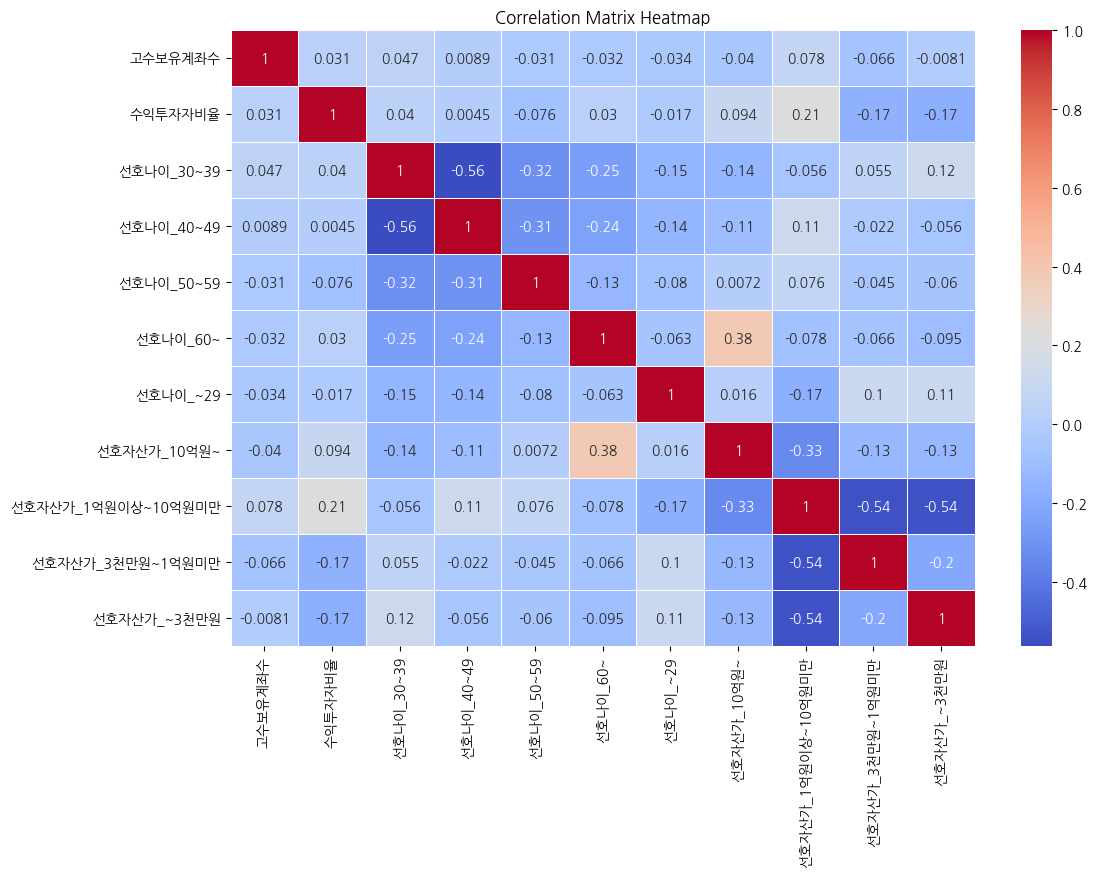

In [14]:
plt.rc('font', family='NaNumGothic') 
plt.rcParams['axes.unicode_minus'] = False
#  세 개의 군집 컬럼을 원핫 인코딩 적용
df_encoded = pd.get_dummies(df_merge[['고수보유계좌수', '수익투자자비율','선호나이', '선호자산가']], columns=['선호나이', '선호자산가'])

# 상관관계 계산
correlation_matrix = df_encoded.corr()

# 결과 출력
# print(correlation_matrix)

# 특정 컬럼 간의 상관관계 시각화 (예: 수익투자자비율과 군집 컬럼들 간의 상관관계)
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix Heatmap')
plt.show()